In [1]:
import pandas as pd
from datetime import datetime, timedelta
import calendar
import requests
import json
import pytz
import settings # environment variables
import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Reading and cleaning car-sharing data

All the data could be downloaded on: http://netlab.ice.ufjf.br/index.php/carsharingdata/

In [2]:
def evo_cleaning(data):
    # only travels with more than 30 minutes of duration, 
    # that is the cancellation time limit of a booking
    data = data.loc[(data['duration'] > 30) | (data['distance'] > 3)]

    data.Start_time = pd.to_datetime(data.Start_time)
    data.End_time = pd.to_datetime(data.End_time)

    # Colleting vehicle ids
    car_ids = list(data.Id.unique())

    # Removing uncommon ids
    # Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
    ids_uncommon = [id for id in car_ids if id.find('-') != -1]
    car_ids = [id for id in car_ids if id.find('-') == -1]

    data = data.loc[~data.Id.isin(ids_uncommon)]
    
    # Removing microseconds from the dates
    data.Start_time = data.Start_time.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
    data.End_time = data.End_time.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
    
    return data

In [3]:
# reading data
evo_data = pd.read_csv('data/evo_travels.csv')
modo_data = pd.read_csv('data/modo_travels.csv')
c2g_data = pd.read_csv('data/car2go_travels.csv', index_col=0)

In [4]:
# cleaning process
# time will have a hour granularity
evo_data = evo_cleaning(evo_data)

modo_data.start = modo_data.start.apply(lambda x: datetime.fromtimestamp(x))
modo_data.start = modo_data.start.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
modo_data.end = modo_data.end.apply(lambda x: datetime.fromtimestamp(x))
modo_data.end = modo_data.end.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))

c2g_data.init_time = c2g_data.init_time.apply(lambda x: datetime.fromtimestamp(x))
c2g_data.init_time = c2g_data.init_time.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
c2g_data.final_time = c2g_data.final_time.apply(lambda x: datetime.fromtimestamp(x))
c2g_data.final_time = c2g_data.final_time.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))

### Preparing the demand series

In [5]:
# organization of the data for the model

# count travel occurency by hour
evo_travel_count = evo_data.Start_time.value_counts(sort=False)
evo_travel_count = evo_travel_count.sort_index()
modo_travel_count = modo_data.start.value_counts(sort=False)
modo_travel_count = modo_travel_count.sort_index()
c2g_travel_count = c2g_data.init_time.value_counts(sort=False)
c2g_travel_count = c2g_travel_count.sort_index()

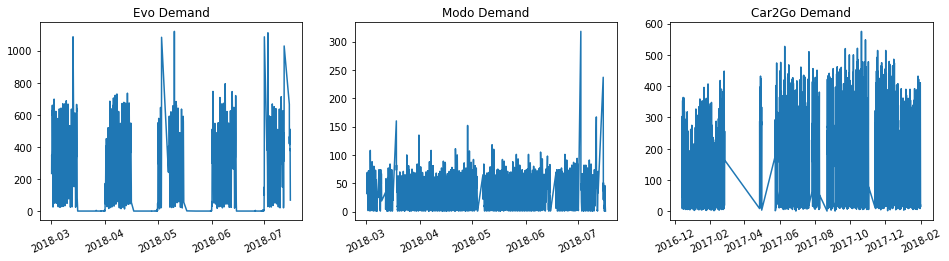

In [7]:
plt.figure(figsize=(16,8))

plt.subplot(2,3,1)
plt.title('Evo Demand')
plt.plot(evo_travel_count.index, evo_travel_count)
plt.xticks(rotation=25)

plt.subplot(2,3,2)
plt.title('Modo Demand')
plt.plot(modo_travel_count.index, modo_travel_count)
plt.xticks(rotation=25)

plt.subplot(2,3,3)
plt.title('Car2Go Demand')
plt.plot(c2g_travel_count.index, c2g_travel_count)
plt.xticks(rotation=25)
plt.show()

## Collecting weather data

The weather data are provided by Dark Sky API: https://darksky.net/dev/docs

### Preparing list of days to collect

In [8]:
# filtering only unique dates from the datetimes
evo_days = list(evo_data.Start_time.apply(lambda x: x.replace(hour=0)).unique())
modo_days = list(modo_data.start.apply(lambda x: x.replace(hour=0)).unique())
c2g_days = list(c2g_data.init_time.apply(lambda x: x.replace(hour=0)).unique())

# list of all unique dates collected
days_to_collect = list(set(evo_days + modo_days + c2g_days))
days_to_collect = list(map(lambda date: pd.to_datetime(date), days_to_collect))
days_to_collect.sort()

# Converting to unix timestamp
timestamps_to_collect = list(map(lambda date: int(pd.Timestamp(date).timestamp()), days_to_collect))

In [9]:
days_to_collect[-8:-1]

[Timestamp('2018-07-07 00:00:00'),
 Timestamp('2018-07-08 00:00:00'),
 Timestamp('2018-07-09 00:00:00'),
 Timestamp('2018-07-10 00:00:00'),
 Timestamp('2018-07-11 00:00:00'),
 Timestamp('2018-07-12 00:00:00'),
 Timestamp('2018-07-15 00:00:00')]

In [10]:
timestamps_to_collect[-8:-1]

[1530932400,
 1531018800,
 1531105200,
 1531191600,
 1531278000,
 1531364400,
 1531623600]

### Making the api requests

In [11]:
# API key
KEY = os.getenv('DARK_SKY_API')

In [12]:
def hourly_weather_request(date, timestamp):
    response = requests.get(
        f'https://api.darksky.net/forecast/{KEY}/49.280116,%20-123.126825,{timestamp}?exclude=currently,flags,daily'
    )

    data = json.loads(response.text)

    hour_list = []
    
    # build dict list for each hour weather
    for hour in range(24):
        date_hour = date + timedelta(hours=hour)
        try:
            hour_list.append({
                date_hour: data['hourly']['data'][hour]
            })
        except Exception as e:
            print(date)
            print(e)
        
    return hour_list

In [13]:
# collecting all days weather
hourly_data = []
for day, timestamp in tqdm(zip(days_to_collect, timestamps_to_collect)):
    hourly_data.append(hourly_weather_request(day, timestamp))

2018-03-12 00:00:00
list index out of range
2018-06-23 00:00:00
list index out of range
2018-06-23 00:00:00
list index out of range
2018-06-24 00:00:00
list index out of range
2018-06-25 00:00:00
list index out of range
2018-06-29 00:00:00
list index out of range



In [14]:
# reorganizing the data as a dataframe
weather_data = pd.DataFrame()

for day in tqdm(hourly_data):
    for hour in day:
        hour_data = pd.DataFrame.from_dict(hour, orient='index')
        weather_data = pd.concat([weather_data, hour_data])

In [15]:
weather_data.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
2016-12-13 00:00:00,30.99,1.0,34.53,0.96,sleet,NaN,0.0236,1.00,sleet,1015.4,Light Sleet,35.55,1481529600,0.0,2.000,101.0,5.30,5.30
2016-12-13 01:00:00,35.02,1.0,34.33,0.97,snow,0.1702,0.0191,1.00,snow,1015.7,Light Snow,35.02,1481533200,0.0,2.000,NaN,4.54,0.00
2016-12-13 02:00:00,29.64,1.0,34.18,0.98,snow,0.2491,0.0275,1.00,snow,1016.4,Light Snow,34.64,1481536800,0.0,1.498,111.0,5.64,5.64
2016-12-13 03:00:00,31.35,1.0,31.49,0.87,snow,0.3165,0.0354,0.43,snow,1017.8,Possible Light Snow,35.02,1481540400,0.0,2.248,111.0,4.22,4.22
2016-12-13 04:00:00,30.17,1.0,34.18,0.97,snow,0.0350,0.0039,1.00,snow,1017.5,Flurries,35.02,1481544000,0.0,3.998,103.0,5.55,5.55


In [ ]:
# save weather dataset
weather_data.to_csv('data/weather_data.csv', encoding='UTF-8')

In [16]:
# read weather dataset
weather_data = pd.read_csv('data/weather_data.csv', index_col=0)
weather_data.index = pd.to_datetime(weather_data.index)

## Creating the carsharing demand datasets

Selecting just few columns of the weather data

In [17]:
weather_data.columns

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon',
       'precipAccumulation', 'precipIntensity', 'precipProbability',
       'precipType', 'pressure', 'summary', 'temperature', 'time', 'uvIndex',
       'visibility', 'windBearing', 'windGust', 'windSpeed'],
      dtype='object')

In [18]:
weather_data = weather_data[['temperature','precipProbability','precipIntensity','visibility']]

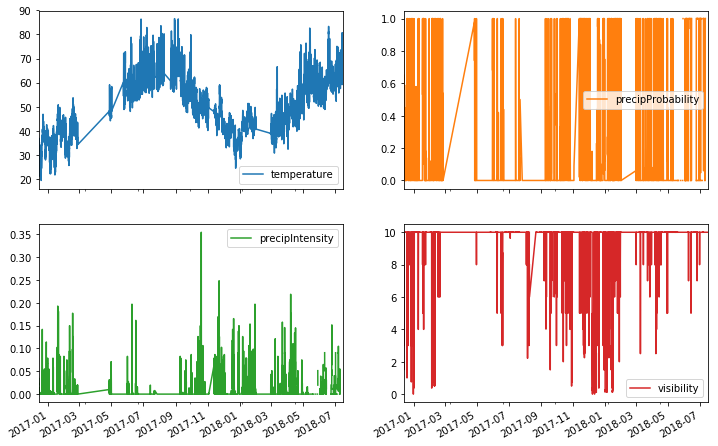

In [19]:
weather_data.plot(subplots=True, layout=(2,2), figsize=(12,8))
plt.show()

### Merge datasets

In [20]:
evo_weather = pd.merge(evo_travel_count.to_frame(name='travels'), weather_data, left_index=True, right_index=True)
modo_weather = pd.merge(modo_travel_count.to_frame(name='travels'), weather_data, left_index=True, right_index=True)
c2g_weather = pd.merge(c2g_travel_count.to_frame(name='travels'), weather_data, left_index=True, right_index=True)

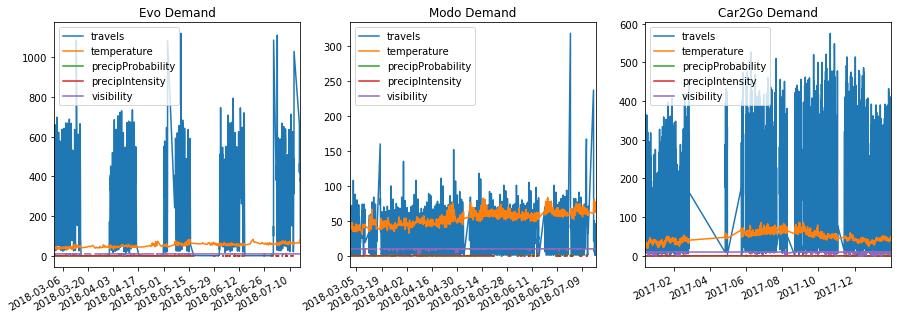

In [21]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

evo_weather.plot(ax=axes[0], title='Evo Demand')
plt.xticks(rotation=25)

modo_weather.plot(ax=axes[1], title='Modo Demand')
plt.xticks(rotation=25)

c2g_weather.plot(ax=axes[2], title='Car2Go Demand')
plt.xticks(rotation=25)

plt.show()

In [22]:
evo_weather.to_csv('data/demand_datasets/evo_demand.csv', encoding='utf-8')
modo_weather.to_csv('data/demand_datasets/modo_demand.csv', encoding='utf-8')
c2g_weather.to_csv('data/demand_datasets/c2g_demand.csv', encoding='utf-8')